SVD Proof-of-Concept Notebook
=============================

This notebook is just to make sure my SVD algorithm is correct, while I figure out how to export the C++ class to R for testing.

In [81]:
# Load modules and data
import numpy as np

L1 = 0

N = 1000
M = 100
K = 5

A = np.ndarray((M,N), dtype=float, buffer=np.array(range(0, N*M), dtype=float))
U = np.random.uniform(-1.0, 1.0, (M, K))
V = np.zeros((K, N))
D = np.zeros((K, K))

U_np, S_np, V_np = np.linalg.svd(A, full_matrices=False)
U_np = U_np * S_np[..., None, :]

TOL = 1e-9
MAX_ITER = 50

In [82]:
# Error measurement
def mse(A, U, V):
    D = A - np.matmul(U, V)
    D = D ** 2
    return np.sum(D) / (D.shape[0] * D.shape[1])

# L2 norm
def norm(x):
    return np.sqrt(np.sum(x * x))

In [83]:
# Solve each K in turn 
print(f"Initial model error:\t{mse(A, U, V)}")
for k in range(K):
    for iter in range(MAX_ITER):
        # Update V[k]
        V[k,:] = np.matmul(U[:,k], A)

        if k > 0:
            for _k in range(0, k):
               V[k,:] -= np.dot(U[:,k], U[:,_k]) * V[_k, :]
        
        V[k, :] /= np.dot(U[:,k], U[:,k])
        V[k,:] /= np.linalg.norm(V[k,:])

        # Update U[k]
        U[:, k] = np.matmul(A, V[k,:].transpose())
        if k > 0:
            for _k in range(0, k):
                U[:, k] -= np.dot(V[k,:], V[_k,:]) * U[:,_k]

        U[:,k] /= np.dot(V[k,:], V[k,:])
        d_k = np.linalg.norm(U[:,k])
        U[:,k] /= d_k
        
    # 'Unscale' U
    U[:,k] *= d_k


    print(f"Model error after K={k+1}:\t{mse(A, U, V)}")
    print(f"numpy SVD implementation error: {mse(A, U_np[:, :k+1], V_np[:k+1, :])}")
    print()

# Calculate final D
for k in range(K):
    d_u = np.linalg.norm(U[:,k])

    U[:,k] /= d_u

    D[k,k] = d_u 

Initial model error:	3333283333.5
Model error after K=1:	20831.671830351246
numpy SVD implementation error: 20831.671830351243

Model error after K=2:	6.143000815159516e-22
numpy SVD implementation error: 1.885277127264609e-21

Model error after K=3:	6.077898437267388e-22
numpy SVD implementation error: 2.5154445953287507e-21

Model error after K=4:	4.0842921540557024e-22
numpy SVD implementation error: 3.089365167521749e-21

Model error after K=5:	4.1296539422757905e-22
numpy SVD implementation error: 3.1161913372946542e-21



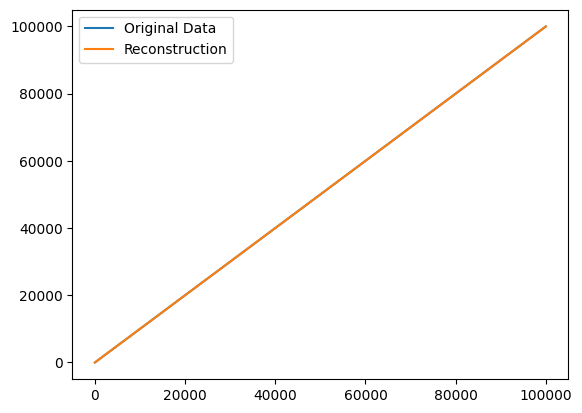

In [84]:
A_approx = np.matmul(np.matmul(U, D), V)

import matplotlib.pyplot as plt
plt.plot(range(0, N*M), A.flatten(), label="Original Data")
plt.plot(range(0, N*M), A_approx.flatten(), label="Reconstruction")
plt.legend()
plt.show()